# Simple Fast Forward Network (FFN)

This is a simple Deep Learning example based on [this tutorial](https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/) and some extensions suggested in the article itself

In [15]:
# Import all necessary modules.

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

These are general variables for your model: they are called **hyperparameters**. They are grouped here for ease of use, in most cases they should be stored in a configuration file. You will see them pop up all over the script.

In [21]:
random_state = 42
test_fraction = 0.2
batch_size = 32
input_size = 8
layers = [
    {'size': 12, 'activation': 'relu'},
    {'size': 8, 'activation': 'relu'},
    {'size': 1, 'activation': 'sigmoid'},
]
epochs = 150

These are just helpful functions. You can have a look at them, but they are not part of the tutorial: they are just here to be used.

In [29]:
def plot_history(history, metrics, restore_weights=True, yscale='linear', save_folder=None):
  """Plot the history af all specified metrics, comparing training and testing metrics."""

  if restore_weights and 'val_loss' in history.history.keys():
    # Find the epoch with the best result (which the model was restored to).
    best_epoch = np.argmin(history.history['val_loss'])
    print(f"Restored weights to epoch: {best_epoch}")
  else:
    best_epoch = None

  # Plot the history of each metric.
  for metric in metrics:
    plt.figure()
    plt.title(metric)
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.yscale(yscale)

    # Trained metric.
    plt.plot(history.history[metric])
    print(f"{metric}: {history.history[metric][best_epoch or len(history.history[metric]) - 1]}")
    
    val_metric = 'val_' + metric
    if val_metric in history.history.keys():
      # Same metric evaluated on the test set.
      plt.plot(history.history[val_metric])
      print(f"{val_metric}: {history.history[val_metric][best_epoch or len(history.history[metric]) - 1]}")

      # Highlight the epoch the weights were restored to.
      if restore_weights:
        plt.plot(best_epoch, history.history[val_metric][best_epoch], 'ro')
    
    plt.legend(['train', 'validation'], loc='best')

    if save_folder:
      plt.savefig(f'{save_folder}/{metric}')
    plt.show()

## Load the data

First of all we need to download the data on our local filesystem. In this case our data is contained in two CSV files freely downloadable from the internet.

In [12]:
DATA_DIR = "/content/data"
DATASET_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
DATASET_PATH = DATA_DIR + "/pima-indians-diabetes.data.csv"
DATASET_DETAILS_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names"
DATASET_DETAILS_PATH = DATA_DIR + "/pima-indians-diabetes.names"

# Create the directory where data is stored. 
!mkdir -p $DATA_DIR
# Download the data.
!wget $DATASET_URL -O $DATASET_PATH
!wget $DATASET_DETAILS_URL -O $DATASET_DETAILS_PATH

--2021-09-12 21:16:01--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23278 (23K) [text/plain]
Saving to: ‘/content/data/pima-indians-diabetes.data.csv’

/content/data/pima- 100%[===================>]  22.73K  --.-KB/s    in 0.002s  

2021-09-12 21:16:01 (10.1 MB/s) - ‘/content/data/pima-indians-diabetes.data.csv’ saved [23278/23278]

--2021-09-12 21:16:02--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.

Now we need to load the data in memory. Note that we want to have input and output in two different variables.

In [13]:
def load_data(csv_path):
  # Load data from the CSV file.
  data = np.loadtxt(csv_path, delimiter=",")
      
  # Split data between input (first 8 columns) and output (last column).
  # Input.
  X = data[:, 0:8]
  # Output.
  y = data[:, 8]

  return X, y

# Load the dataset.
X, y = load_data(csv_path=DATASET_PATH)

Once the data is loaded we want to split the data between a training and a validation dataset.  
For more information see: https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/

The random_state parameter ensures reproducibility.  
For more information see: https://machinelearningmastery.com/different-results-each-time-in-machine-learning/

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_fraction, shuffle=True, random_state=random_state)

## Model

Once we are done with the data we can define the models. Keras offers two main ways to build a model: the Sequential API, easier, but more limited and the Functional API, more complex, but much more advanced.

For more informations on Keras functional API see: https://machinelearningmastery.com/keras-functional-api-deep-learning/

In [25]:
def get_model_sequential(input_dim: int, layers):
  """Build a model with Keras Sequential API."""

  model = Sequential()
  # First layer.
  model.add(Dense(layers[0]['size'], input_dim=input_dim, activation=layers[0]['activation']))
  # Other layers.
  for layer in layers[1:]:
    model.add(Dense(layer['size'], activation=layer['activation']))
  # Return the finished model.
  return model


def get_model_functional(input_dim: int, layers):
  """Build a model with Keras Functional API."""

  # Input layer.
  input_layer = Input(shape=(input_dim,))
  output = input_layer
  # Each layer takes the previous (output) as input.
  for layer in layers:
    output = Dense(layer['size'], activation=layer['activation'])(output)
  # Return the finished model.
  return Model(inputs=input_layer, outputs=[output])

In [36]:
# Create the models.
model_seq = get_model_sequential(input_size, layers)
model_func = get_model_functional(input_size, layers)
# Print the details of each model.
print("## Sequential model ##")
print(model_seq.summary())
print("\n## Functional model ##")
print(model_func.summary())

## Sequential model ##
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 12)                108       
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 9         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________
None

## Functional model ##
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 12)              

The two models we have created are perfectly equivalent, so just choose one or the other: you will see that the results do not change.

In [37]:
model = model_seq
# model = model_func

## Training

Now the central step: we feed our data to our model and train it. Before, however, we have to define some things.

For more information on losses, optimizers, metrics, callbacks search the Keras documentation and read:
https://machinelearningmastery.com/5-step-life-cycle-neural-network-models-keras/
https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/
https://machinelearningmastery.com/tour-of-optimization-algorithms/ 
https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

You can also define your own functions as losses, metrics or callbacks.

Epoch 1/150
20/20 [==============================] - 1s 9ms/step - loss: 23.0561 - accuracy: 0.3550 - val_loss: 12.7240 - val_accuracy: 0.3961
Epoch 2/150
20/20 [==============================] - 0s 3ms/step - loss: 13.1707 - accuracy: 0.4397 - val_loss: 8.0536 - val_accuracy: 0.5455
Epoch 3/150
20/20 [==============================] - 0s 2ms/step - loss: 8.6044 - accuracy: 0.4609 - val_loss: 4.9458 - val_accuracy: 0.5649
Epoch 4/150
20/20 [==============================] - 0s 3ms/step - loss: 4.9391 - accuracy: 0.5261 - val_loss: 2.9624 - val_accuracy: 0.6494
Epoch 5/150
20/20 [==============================] - 0s 3ms/step - loss: 2.9149 - accuracy: 0.6124 - val_loss: 1.7872 - val_accuracy: 0.6558
Epoch 6/150
20/20 [==============================] - 0s 3ms/step - loss: 1.8576 - accuracy: 0.6059 - val_loss: 1.2896 - val_accuracy: 0.6818
Epoch 7/150
20/20 [==============================] - 0s 4ms/step - loss: 1.4660 - accuracy: 0.6221 - val_loss: 1.1449 - val_accuracy: 0.6688
Epoch 8/15

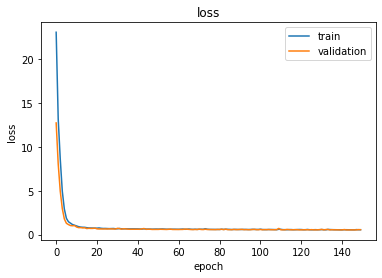

accuracy: 0.7166123986244202
val_accuracy: 0.7142857313156128


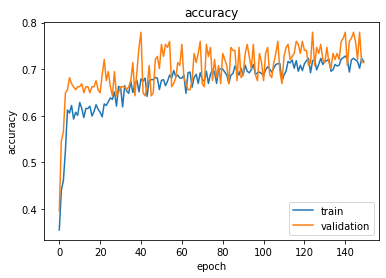

In [38]:
PLOT_DIR = "/content/plots/"
!mkdir -p $PLOT_DIR

# Our case is a classification problem, so we'll use binary crossentropy loss and accuracy metric.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the keras model on the dataset.
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
# Output of the history.
plot_history(history, metrics=['loss', 'accuracy'], restore_weights=False, save_folder=PLOT_DIR)

## Model saving and loading

Once training is finished we can saved the resulting model with the training weights. This can be loaded at a second time (or, for example, moved to another machine and loaded there) without having to perform training once again.

For more information: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [39]:
model.save('models/model') 

# The trained model can be saved to be retrieved later, without re-training it.
# e.g. model = keras.models.load_model('path/to/model')

INFO:tensorflow:Assets written to: models/model/assets


## Evaluation

The trained model can be used to perform predictions. In this case we perform predictions on already used data (the validation dataset), but we could use this on new, never seen before, data.

In [40]:
predictions, accuracy = model.evaluate(X_val, y_val)
print(f'Accuracy: {accuracy*100:.2f}')

5/5 [==============================] - 0s 2ms/step - loss: 0.5583 - accuracy: 0.7143
Accuracy: 71.43
